## Посмотрим датасет (какие столбцы есть и какие пропуски. Примем решение, что делать с пропусками)

In [15]:
import pandas as pd
from scipy.stats import f_oneway, ttest_ind, kruskal, levene, mannwhitneyu, shapiro, chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt


data = pd.read_csv('data_graduates_university_specialty_124_v20240709.csv', sep=';')

print("Общая информация о данных")
print(data.info())

Общая информация о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599971 entries, 0 to 599970
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   object_level       599971 non-null  object 
 1   object_name        599971 non-null  object 
 2   gender             599971 non-null  object 
 3   education_level    599971 non-null  object 
 4   year               599971 non-null  int64  
 5   university         599971 non-null  object 
 6   specialty_section  599971 non-null  object 
 7   specialty          599971 non-null  object 
 8   specialty_code     599971 non-null  object 
 9   count_graduate     599971 non-null  int64  
 10  percent_employed   599971 non-null  float64
 11  average_salary     261227 non-null  float64
 12  oktmo              599971 non-null  int64  
 13  okato              599971 non-null  int64  
dtypes: float64(2), int64(4), object(8)
memory usage: 64.1+ MB
None


In [3]:
missing_values = data.isnull().sum()
print("\nКоличество пропусков по столбцам:")
print(missing_values)


Количество пропусков по столбцам:
object_level              0
object_name               0
gender                    0
education_level           0
year                      0
university                0
specialty_section         0
specialty                 0
specialty_code            0
count_graduate            0
percent_employed          0
average_salary       338744
oktmo                     0
okato                     0
dtype: int64


### Видим много пропусков в average_salary (больше половины значений). Не будем учитывать их при анализе, так что удалим эти строки с пропусками.

In [4]:
data = data.dropna(subset=['average_salary'])
missing_values = data.isnull().sum()
print("\nКоличество пропусков по столбцам:")
print(missing_values)


Количество пропусков по столбцам:
object_level         0
object_name          0
gender               0
education_level      0
year                 0
university           0
specialty_section    0
specialty            0
specialty_code       0
count_graduate       0
percent_employed     0
average_salary       0
oktmo                0
okato                0
dtype: int64


# Гипотеза 1. Средняя зарплата зависит от уровня образования

In [16]:
# Посмотрим на уникальные уровни образования
education_levels = data['education_level'].unique()
print("Уровни образования:", education_levels)

Уровни образования: ['СПО: квалифицированные рабочие и служащие'
 'СПО: специалисты среднего звена' 'Бакалавриат, специалитет'
 'Магистратура']


In [12]:
# Группировка данных по уровню образования
groups = [data[data['education_level'] == level]['average_salary'] for level in education_levels]

In [14]:
from scipy.stats import kruskal, levene, f_oneway

# Проверка условий для ANOVA
levene_test = levene(*groups)

# Если условия равенства дисперсий соблюдаются, используем ANOVA; иначе — Краскела-Уоллиса
if levene_test.pvalue > 0.05:
    result = f_oneway(*groups)
    print("ANOVA p-value:", result.pvalue)
else:
    result = kruskal(*groups)
    print("Краскела-Уоллиса p-value:", result.pvalue)

Краскела-Уоллиса p-value: 0.0


### Вывод: p-value = 0.0 означает, что вероятность случайного возникновения таких различий крайне мала (меньше 0.05). Следовательно, можно с высокой степенью уверенности заявить, что на самом деле средняя зарплата зависит от уровня образования  

# Гипотеза 2. Доля трудоустроенных выпускников зависит от пола

In [17]:
# Разделим данные по полу
male_employed = data[data['gender'] == 'Мужской']['percent_employed']
female_employed = data[data['gender'] == 'Женский']['percent_employed']

Манна-Уитни p-value: 0.0


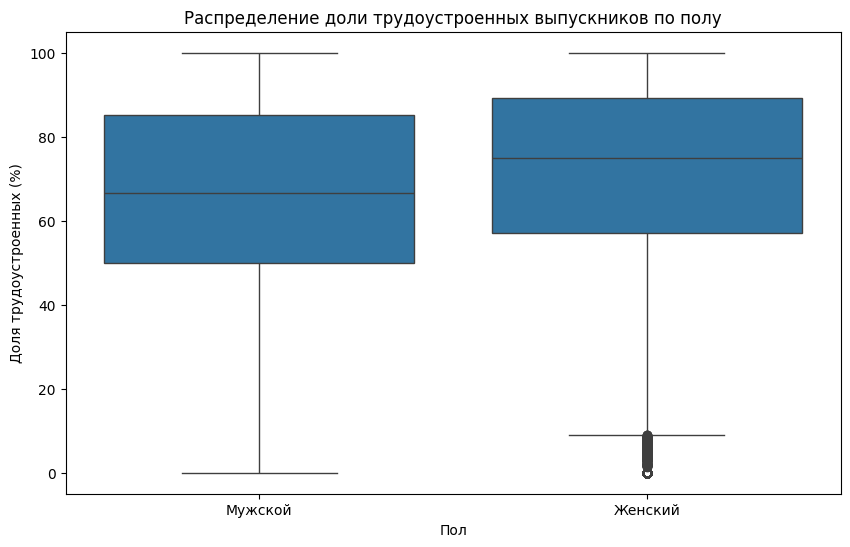

In [25]:
from scipy.stats import ttest_ind, mannwhitneyu, levene

# Разделим данные по полу
male_employed = data[data['gender'] == 'Мужской']['percent_employed']
female_employed = data[data['gender'] == 'Женский']['percent_employed']

# Проверка равенства дисперсий с помощью теста Левена
levene_test = levene(male_employed, female_employed)

# Выбор теста на основе результатов теста Левена
if levene_test.pvalue > 0.05:
    # Если дисперсии равны, используем t-тест для независимых выборок
    result = ttest_ind(male_employed, female_employed)
    print("t-тест p-value:", result.pvalue)
else:
    # В противном случае используем тест Манна-Уитни
    result = mannwhitneyu(male_employed, female_employed)
    print("Манна-Уитни p-value:", result.pvalue)

plt.figure(figsize=(10, 6))
sns.boxplot(data=data[data['gender'].isin(['Мужской', 'Женский'])], x='gender', y='percent_employed')
plt.title('Распределение доли трудоустроенных выпускников по полу')
plt.xlabel('Пол')
plt.ylabel('Доля трудоустроенных (%)')
plt.show()

## Вывод: p-value = 0.0 говорит о том, что вероятность случайного возникновения таких различий крайне мала (меньше 0.05). Это позволяет  утверждать, что доля трудоустроенных выпускников зависит от пола.
## Также можем видеть на диаграмме наличие выбросов (в женской группе), что может свидетельствовать о меньшей трудоустроенности в некоторых случаях.

# Гипотеза 3. Выпускники крупных образовательных организаций имеют более высокий процент трудоустройства

## Заметка: изменили шкалу по оси Х (через логарифм)  

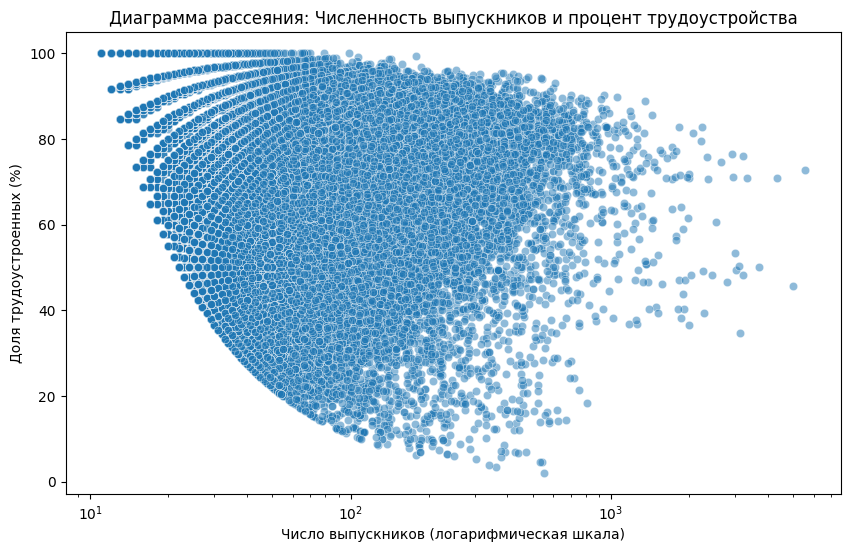

Коэффициент корреляции Спирмена: -0.245919
p-value: 0.00000000000000000000


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

# Построим диаграмму рассеяния с логарифмической осью X
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='count_graduate', y='percent_employed', alpha=0.5)
plt.xscale('log')  # Устанавливаем логарифмический масштаб по оси X
plt.title('Диаграмма рассеяния: Численность выпускников и процент трудоустройства')
plt.xlabel('Число выпускников (логарифмическая шкала)')
plt.ylabel('Доля трудоустроенных (%)')
plt.show()

# Рассчитаем коэффициент корреляции Спирмена для оригинальных данных
corr, p_value = spearmanr(data['count_graduate'], data['percent_employed'])

# Выведем результаты
print(f"Коэффициент корреляции Спирмена: {corr:.6f}")
print(f"p-value: {p_value:.20f}")

## Вывод: 
1) Корреляция Спирмана слабая и отрицательная (-0.115006), но она статистически значима (p-value < 0.05). Это означает, что, хотя формально существует связь, она очень слабая и указывает на незначительное снижение процента трудоустройства с ростом численности выпускников.
2) Для небольших групп (до нескольких десятков) процент трудоустройства часто высокий. (Скорее всего направления подготовки для гос.сектора)
3) В больших группах (более 1000) процент трудоустройства больше разбросан, но в среднем ниже.

# Гипотеза 4. Разница зарплаты выпускников по регионам (Москва, Санкт-Петербург, Казань, Владивосток)

Краскела-Уоллиса p-value: 2.0271760727672614e-123


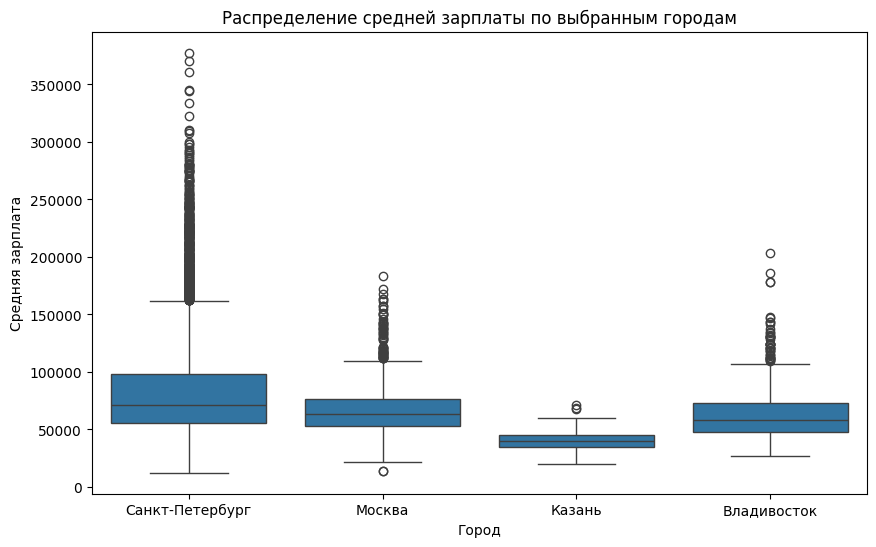

In [13]:
# Фильтрация по городам на основе ключевых слов в названии университета
city_keywords = {
    'Москва': 'Москва', 
    'Санкт-Петербург': 'Санкт-Петербург', 
    'Казань': 'Казань', 
    'Владивосток': 'Владивосток'
}

# Создаем новый столбец для города на основе ключевых слов в названии университета
data['city'] = data['university'].apply(lambda x: next((city for city, keyword in city_keywords.items() if keyword in x), None))

# Фильтруем данные, оставляя только нужные города
cities_of_interest = ['Москва', 'Санкт-Петербург', 'Казань', 'Владивосток']
filtered_data = data[data['city'].isin(cities_of_interest)]

# Удаляем строки с пропусками в столбце average_salary
filtered_data = filtered_data.dropna(subset=['average_salary'])

# Фильтруем только города с количеством значений `average_salary` >= 10
filtered_data = filtered_data.groupby('city').filter(lambda x: x['average_salary'].count() >= 10)

# Группировка данных по городам для теста Крускала-Уоллиса
groups = [filtered_data[filtered_data['city'] == city]['average_salary'] for city in cities_of_interest]

# Применяем тест Крускала-Уоллиса для проверки различий
result = kruskal(*groups)
print("Краскела-Уоллиса p-value:", result.pvalue)

# Визуализация: ящичковая диаграмма средней зарплаты по выбранным городам
plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_data, x='city', y='average_salary')
plt.title('Распределение средней зарплаты по выбранным городам')
plt.xlabel('Город')
plt.ylabel('Средняя зарплата')
plt.show()

## Выводы: 

    1)Краскела-Уоллиса p-value значительно меньше 0.05. Это указывает на статистически значимую разницу в средней зарплате выпускников между выбранными городами (Москва, Санкт-Петербург, Казань и Владивосток).   
    2) Выпускники Казанских учебных заведений получают меньшие зарплаты по сравнению с Московой, Санкт-Петербургом и Владивостоком.
    3) Санкт-Петербург имеет более высокую медианную зарплату по сравнению с другими городами, а также показывает большую вариативность зарплат, включая множество выбросов (высокие зарплаты).
    4) Зарплаты выпускников учебных заведений Москвы и Владивостока схожи.

# Гипотеза 5. Доля трудоустроенных выпускников зависит от направления подготовки

Таблица сопряженности:
 employment_category                                 Высокая  Низкая
specialty_section                                                  
Авиационная и ракетно-космическая техника              1679     568
Архитектура                                            1840    1937
Аэронавигация и эксплуатация авиационной и раке...      767     551
Биологические науки                                    2066    1163
Ветеринария и зоотехния                                2851    3226
Изобразительное и прикладные виды искусств             4020    9992
Информатика и вычислительная техника                  19252   19984
Информационная безопасность                            2914    1810
Искусствознание                                         534     478
История и археология                                   3330    3037
Клиническая медицина                                   6161    5154
Компьютерные и информационные науки                    1741     951
Культуроведение и социок

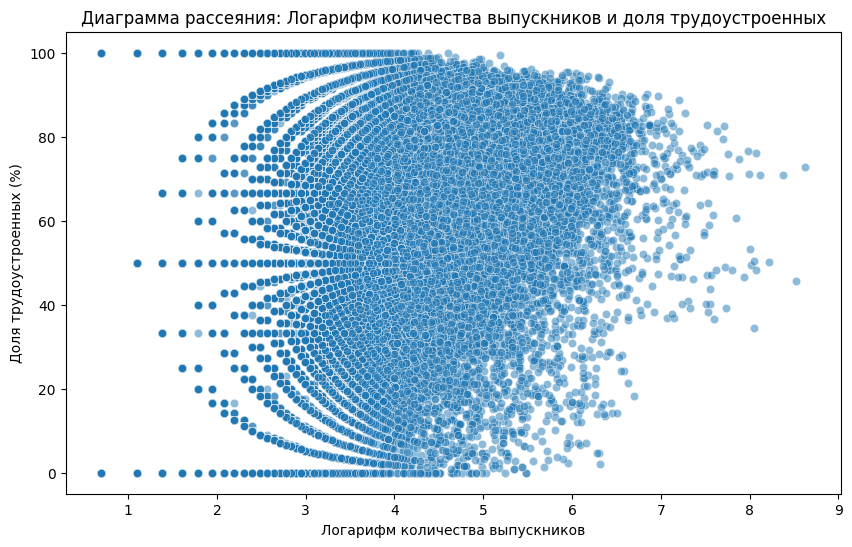

In [16]:
# Преобразуем количество выпускников (размер рынка) в логарифм
data['log_market_size'] = np.log1p(data['count_graduate'])  # log1p применяется, чтобы избежать логарифма от 0

# Создаем категорию для трудоустройства на основе медианы
median_employment = data['percent_employed'].median()
data['employment_category'] = data['percent_employed'].apply(lambda x: 'Высокая' if x >= median_employment else 'Низкая')

# Создаем таблицу сопряженности для направления подготовки и категории трудоустройства
contingency_table = pd.crosstab(data['specialty_section'], data['employment_category'])
print("Таблица сопряженности:\n", contingency_table)

# Применяем χ²-тест для таблицы сопряженности
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print("χ²-тест p-value:", p_value)

# Визуализация: диаграмма рассеяния логарифма количества выпускников и доли трудоустроенных
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='log_market_size', y='percent_employed', alpha=0.5)
plt.title('Диаграмма рассеяния: Логарифм количества выпускников и доля трудоустроенных')
plt.xlabel('Логарифм количества выпускников')
plt.ylabel('Доля трудоустроенных (%)')
plt.show()

## Выводы: χ²-тест p-value: 0.0 - указывает на статистически значимую зависимость между направлением подготовки и долей трудоустроенных выпускников.
## Размер группы влияет на процент трудоустройства: В малых группах процент трудоустроенных выше, а в крупных — более переменный и может быть ниже.